# Vehicle Detection

*Much code adapted from Udacity's Vehicle Detection and Tracking Lesson*

In [ ]:
import numpy as np
import cv2


class Line:
    """
    A Line is defined from two points (x1, y1) and (x2, y2) as follows:
    y - y1 = (y2 - y1) / (x2 - x1) * (x - x1)
    Each line has its own slope and intercept (bias).
    """
    def __init__(self, x1, y1, x2, y2):

        self.x1 = np.float32(x1)
        self.y1 = np.float32(y1)
        self.x2 = np.float32(x2)
        self.y2 = np.float32(y2)

        self.slope = self.compute_slope()
        self.bias = self.compute_bias()

    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1 + np.finfo(float).eps)

    def compute_bias(self):
        return self.y1 - self.slope * self.x1

    def get_coords(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])

    def set_coords(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def draw(self, img, color=[255, 0, 0], thickness=10):
        cv2.line(img, (self.x1, self.y1), (self.x2, self.y2), color, thickness)

In [ ]:
import numpy as np
import cv2
from Line import Line


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask


def hough_lines_detection(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    Returns resulting blend image computed as follows:

    initial_img * α + img * β + λ
    """
    img = np.uint8(img)
    if len(img.shape) is 2:
        img = np.dstack((img, np.zeros_like(img), np.zeros_like(img)))

    return cv2.addWeighted(initial_img, α, img, β, λ)


def compute_lane_from_candidates(line_candidates, img_shape):
    """
    Compute lines that approximate the position of both road lanes.

    :param line_candidates: lines from hough transform
    :param img_shape: shape of image to which hough transform was applied
    :return: lines that approximate left and right lane position
    """

    # separate candidate lines according to their slope
    pos_lines = [l for l in line_candidates if l.slope > 0]
    neg_lines = [l for l in line_candidates if l.slope < 0]

    # interpolate biases and slopes to compute equation of line that approximates left lane
    # median is employed to filter outliers
    neg_bias = np.median([l.bias for l in neg_lines]).astype(int)
    neg_slope = np.median([l.slope for l in neg_lines])
    x1, y1 = 0, neg_bias
    x2, y2 = -np.int32(np.round(neg_bias / neg_slope)), 0
    left_lane = Line(x1, y1, x2, y2)

    # interpolate biases and slopes to compute equation of line that approximates right lane
    # median is employed to filter outliers
    lane_right_bias = np.median([l.bias for l in pos_lines]).astype(int)
    lane_right_slope = np.median([l.slope for l in pos_lines])
    x1, y1 = 0, lane_right_bias
    x2, y2 = np.int32(np.round((img_shape[0] - lane_right_bias) / lane_right_slope)), img_shape[0]
    right_lane = Line(x1, y1, x2, y2)

    return left_lane, right_lane


def get_lane_lines(color_image, solid_lines=True):
    """
    This function take as input a color road frame and tries to infer the lane lines in the image.
    :param color_image: input frame
    :param solid_lines: if True, only selected lane lines are returned. If False, all candidate lines are returned.
    :return: list of (candidate) lane lines.
    """
    # resize to 960 x 540
    color_image = cv2.resize(color_image, (960, 540))

    # convert to grayscale
    img_gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    # perform gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (17, 17), 0)

    # perform edge detection
    img_edge = cv2.Canny(img_blur, threshold1=50, threshold2=80)

    # perform hough transform
    detected_lines = hough_lines_detection(img=img_edge,
                                           rho=2,
                                           theta=np.pi / 180,
                                           threshold=1,
                                           min_line_len=15,
                                           max_line_gap=5)

    # convert (x1, y1, x2, y2) tuples into Lines
    detected_lines = [Line(l[0][0], l[0][1], l[0][2], l[0][3]) for l in detected_lines]

    # if 'solid_lines' infer the two lane lines
    if solid_lines:
        candidate_lines = []
        for line in detected_lines:
                # consider only lines with slope between 30 and 60 degrees
                if 0.5 <= np.abs(line.slope) <= 2:
                    candidate_lines.append(line)
        # interpolate lines candidates to find both lanes
        lane_lines = compute_lane_from_candidates(candidate_lines, img_gray.shape)
    else:
        # if not solid_lines, just return the hough transform output
        lane_lines = detected_lines

    return lane_lines


def smoothen_over_time(lane_lines):
    """
    Smooth the lane line inference over a window of frames and returns the average lines.
    """

    avg_line_lt = np.zeros((len(lane_lines), 4))
    avg_line_rt = np.zeros((len(lane_lines), 4))

    for t in range(0, len(lane_lines)):
        avg_line_lt[t] += lane_lines[t][0].get_coords()
        avg_line_rt[t] += lane_lines[t][1].get_coords()

    return Line(*np.mean(avg_line_lt, axis=0)), Line(*np.mean(avg_line_rt, axis=0))


def color_frame_pipeline(frames, solid_lines=True, temporal_smoothing=True):
    """
    Entry point for lane detection pipeline. Takes as input a list of frames (RGB) and returns an image (RGB)
    with overlaid the inferred road lanes. Eventually, len(frames)==1 in the case of a single image.
    """
    is_videoclip = len(frames) > 0

    img_h, img_w = frames[0].shape[0], frames[0].shape[1]

    lane_lines = []
    for t in range(0, len(frames)):
        inferred_lanes = get_lane_lines(color_image=frames[t], solid_lines=solid_lines)
        lane_lines.append(inferred_lanes)

    if temporal_smoothing and solid_lines:
        lane_lines = smoothen_over_time(lane_lines)
    else:
        lane_lines = lane_lines[0]

    # prepare empty mask on which lines are drawn
    line_img = np.zeros(shape=(img_h, img_w))

    # draw lanes found
    for lane in lane_lines:
        lane.draw(line_img)

    # keep only region of interest by masking
    vertices = np.array([[(50, img_h),
                          (450, 310),
                          (490, 310),
                          (img_w - 50, img_h)]],
                        dtype=np.int32)
    img_masked, _ = region_of_interest(line_img, vertices)

    # make blend on color image
    img_color = frames[-1] if is_videoclip else frames[0]
    img_blend = weighted_img(img_masked, img_color, α=0.8, β=1., λ=0.)

    return img_blend

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join, basename
from collections import deque
from lane_detection import color_frame_pipeline


if __name__ == '__main__':

    resize_h, resize_w = 540, 960

    verbose = True
    if verbose:
        plt.ion()
        figManager = plt.get_current_fig_manager()
        #print(figManager.window)

    # test on images
    test_images_dir = join('data', 'test_images')
    test_images = [join(test_images_dir, name) for name in os.listdir(test_images_dir)]

    for test_img in test_images:

        print('Processing image: {}'.format(test_img))

        out_path = join('out', 'images', basename(test_img))
        in_image = cv2.cvtColor(cv2.imread(test_img, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        out_image = color_frame_pipeline([in_image], solid_lines=True)
        cv2.imwrite(out_path, cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))
        if verbose:
            plt.imshow(out_image)
            plt.waitforbuttonpress()
    plt.close('all')

    # test on videos
    test_videos_dir = join('data', 'test_videos')
    test_videos = [join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]

    for test_video in test_videos:

        print('Processing video: {}'.format(test_video))

        cap = cv2.VideoCapture(test_video)
        out = cv2.VideoWriter(join('out', 'videos', basename(test_video)),
                              fourcc=cv2.VideoWriter_fourcc(*'DIVX'),
                              fps=20.0, frameSize=(resize_w, resize_h))

        frame_buffer = deque(maxlen=10)
        while cap.isOpened():
            ret, color_frame = cap.read()
            if ret:
                color_frame = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                color_frame = cv2.resize(color_frame, (resize_w, resize_h))
                frame_buffer.append(color_frame)
                blend_frame = color_frame_pipeline(frames=frame_buffer, solid_lines=True, temporal_smoothing=True)
                out.write(cv2.cvtColor(blend_frame, cv2.COLOR_RGB2BGR))
                cv2.imshow('blend', cv2.cvtColor(blend_frame, cv2.COLOR_RGB2BGR)), cv2.waitKey(1)
            else:
                break
        cap.release()
        out.release()
        cv2.destroyAllWindows()




In [43]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from helperfunctions import *

### 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier (e.g. a Linear SVM classifier)


#### 1.1 Set up helper functions for extracting HOG and colour features

See `helperfunctions.py`

In [44]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

## 0. Default parameters
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()
image_file_name = "hogviz/rgb_ss1616_hb_16_TTT/" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel)
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

image = mpimg.imread('test_images/test1.jpg')
heatmap_template = np.zeros_like(image[:, :, 0]).astype(np.float)

## 1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and
# train a classifier (e.g. a Linear SVM classifier)¶

## Helper functions for extracting HOG and colour features

# Adapted from Udacity L22 lesson_functions.py

def normalise(image):
    return (image - image.mean()) / (image.max() - image.min())

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     viz=False, viz_only=False, hog_viz_name="", viz_title="HOG Viz"):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if viz == True:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature, hog_image = get_hog_features(feature_image[:, :, channel],
                                                                  orient, pix_per_cell, cell_per_block,
                                                                  vis=True, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features, hog_image = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                               pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                # Plot HOG visualisation

                if viz_only == True:
                    fig = plt.figure()
                    plt.imshow(hog_image)
                    plt.title(viz_title)
                    plt.savefig(hog_viz_name, bbox_inches='tight')

                else:
                    fig = plt.figure()
                    plt.subplot(121)
                    plt.imshow(image)
                    plt.title('Example Image')
                    plt.subplot(122)
                    plt.imshow(hog_image)
                    plt.title('Example HOG viz')
                    plt.savefig(hog_viz_name + "_double", bbox_inches='tight')

            else:
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_feature = get_hog_features(feature_image[:, :, channel],
                                                       orient, pix_per_cell, cell_per_block,
                                                       vis=False, feature_vec=True)
                        hog_features.append(hog_feature)
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), polygon_mask=None):
    """Returns all windows to search in an image.
    No classification has been done at this stage.
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Initialize a list to append window positions to
    window_list = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            if polygon_mask is not None:
                if polygon_mask[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    """Returns a list of windows the classifier has predicted contain cars."""
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        # print("features: ", features)

        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # print("Test features: ", test_features)
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows


## 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to
## reject outliers and follow detected vehicles.



def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `box_list` added to it.
    `box_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def create_heatmaps(all_bboxes, recent_frames_used=20, threshold=5):
    """
    Produces a heatmap for each frame in `all_bboxes` and returns
    an array of heatmaps.

    `all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    heatmap_list = []

    for idx, boxlist in enumerate(all_bboxes):
        # Produce heatmap for the most recent e.g. 10 frames:
        # print("Boxlist: ", boxlist)
        idx_start = max(idx - recent_frames_used, 0)
        idx_heatmap = heatmap_template
        for boxlist2 in all_bboxes[idx_start:idx + 1]:
            idx_heatmap = add_heat(idx_heatmap, boxlist2)
            # print("Boxlist2: ", boxlist2)

        # Apply threshold
        idx_heatmap = apply_threshold(idx_heatmap, threshold)

        # Add heatmap to list of heatmaps
        heatmap_list.append(idx_heatmap)
        plt.imshow(idx_heatmap, cmap="hot")

        # Don't know what this is for:
        # final_map = np.clip(heat - 2, 0, 255)
    return heatmap_list

## 5. Estimate a bounding box for vehicles detected.

# Combine multiple detections

def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

#### 1.2 Prepare data for classifier (extract features)

In [45]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*/*.png')
notcars = glob.glob('non-vehicles/*/*/*.png')

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

vehicles/vehicles/KITTI_extracted/1806.png
non-vehicles/non-vehicles/Extras/extra383.png


[array([0.05768211, 0.01182273, 0.02216091, ..., 0.02530324, 0.01050966,
        0.01120453])]

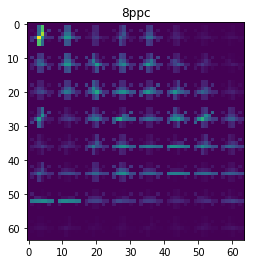

In [46]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()

# Parameters below for saving data for future reference
image_file_name = "hogviz/" + str(color_space) + "_ss" + str(spatial_size[0]) + str(spatial_size[1]) + "_hb" + str(hist_bins) + "_TTT_" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel) + "_wdw" \
                    #+ str(xy_window_size[0]) + str(xy_window_size[1]) + "_olp" \
                    #+ str(xy_overlap_size[0]) + str(xy_overlap_size[1])
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

sample_car = [cars[42]]
sample_notcar = [notcars[42]]

# Plot HOG visualisation
extract_features(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=True, viz_title=image_title, hog_viz_name=image_file_name)

In [47]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 5 orientations 8 pixels per cell and 5 cells per block
Feature vector length: 6000


#### 1.3 Train classifier

In [48]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

# Log training parameters and results

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

15.8764 Seconds to train SVC...
Test Accuracy of SVC =  0.97522523

Parameters:
color_space:  YCrCb
orient:  5
pix_per_cell:  8
cell_per_block:  5
hog_channel:  ALL
spatial_size:  (16, 16)
hist_bins:  24
spatial_feat:  False
hist_feat:  False
hog_feat:  True


### 2. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [49]:
def draw_on_image(testimage_number):
    # Read in image
    image = mpimg.imread('test_images/test' + str(testimage_number) + '.jpg')
    draw_image = np.copy(image)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Normalise image
    # image = normalise(image)
    # print(image, image.shape)
    
    # Get list of windows to search at this stage.
    windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    # Plot image with bounding boxes drawn.
    plt.title(image_title)
    plt.imshow(window_img)
    plt.savefig(image_file_name + "_window_test" + str(testimage_number) + ".png")

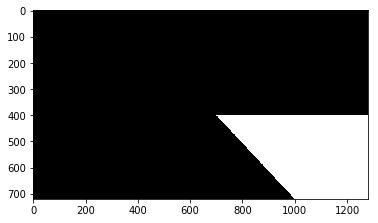

In [50]:
mask = np.zeros_like(mpimg.imread('test_images/test1.jpg')[:,:,0])
vertices = np.array([[(700,400),(1000,720),(1280,720),(1280,400)]])
mask = cv2.fillPoly(mask, vertices, 1)
plt.imshow(mask, cmap="gray")

In [51]:
windows = slide_window(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask)

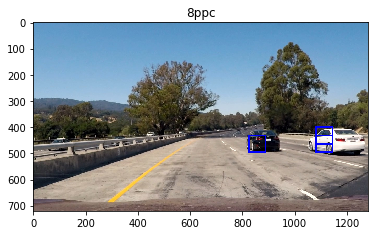

In [52]:
draw_on_image(1)

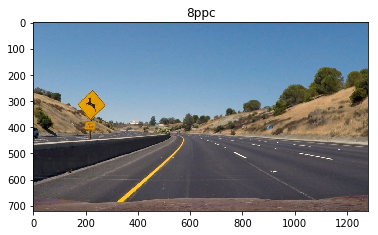

In [53]:
draw_on_image(2)

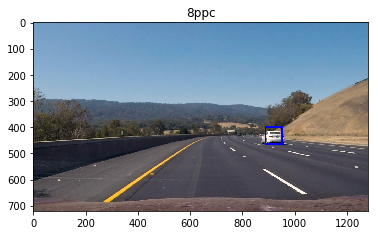

In [54]:
draw_on_image(3)

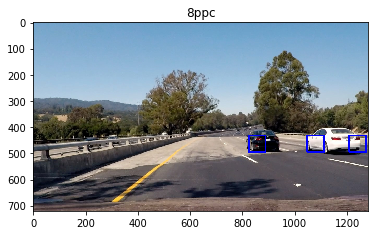

In [55]:
draw_on_image(4)

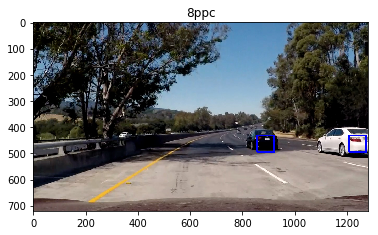

In [56]:
draw_on_image(5)

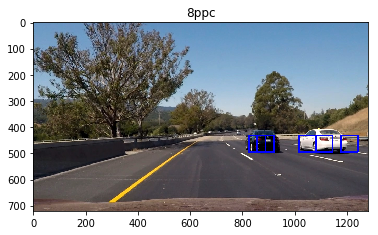

In [57]:
draw_on_image(6)

### 4. Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

#### 4.1 Streamline image pipeline

In [58]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    global bboxes_list
    
    # Normalise image
    # input_image = normalise(input_image)
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

#### 4.2 Convert image pipeline into video pipeline

In [59]:
def add_bboxes_to_list(image):
    """Adds bounding boxes in `image` to global `bboxes_list`.
    Returns image with bounding boxes drawn.
    """
    return add_bboxes(image, windows, svc, X_scaler)

[MoviePy reference](https://zulko.github.io/moviepy/crash_course/crash_course.html)

#### 4.3 Create heat map

In [60]:
def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

### 5. Estimate a bounding box for vehicles detected.

In [65]:
def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    # Add bounding boxes from this frame
    add_bboxes(image, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    # Construct heatmap
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    # Label regions
    labels = label(frame_heatmap)
    
    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [66]:
def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

                                                                
t:   0%|          | 1/1260 [08:55<187:07:39, 535.08s/it, now=None]
                                                                  
t:   0%|          | 1/1260 [07:16<152:49:36, 436.99s/it, now=None]

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Hot windows:  []
Moviepy - Building video output_v5.mp4.
Moviepy - Writing video output_v5.mp4

Hot windows:  []


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file output_v5.mp4:

 b"Unrecognized option 'preset'.\nError splitting the argument list: Option not found\n"

Bounding boxes:  [[], []]


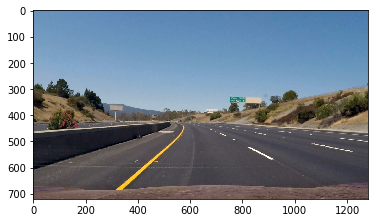

In [67]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v5.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

In [64]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [ ]:
import moviepy.editor as mp
clip = mp.VideoFileClip("output_v5.mp4")
clip_resized = clip.resize(height=540) # make the height 360px ( According to moviePy documenation The width is then computed so that the width/height ratio is conserved.)
clip_resized.write_videofile("output_v5_rs.mp4")